In [220]:
from data import Data
import os

import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics



%matplotlib inline

In [130]:
Data()

for file_name in os.listdir('.'):
    if file_name.endswith('.csv'):
        print(file_name)
        


CSV files successfully generated
canada_cases.csv
bc_cases.csv


# Examining Data

We first examine Covid-19 data in all provinces of Canada

In [3]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d')
canada_data = pd.read_csv('canada_cases.csv', parse_dates=['Date'], date_parser=d_parser)
canada_data.set_index('Date', inplace=True)

In [4]:
canada_data.tail()

,Num_of_days,New_Cases,New_Death,New_Recoveries,Total_Cases,Total_Death,Total_Recoveries
Date,,,,,,,
2020-12-06,317,7003,88,5033,420210,12716,334150
2020-12-07,318,6551,104,9688,426761,12820,343838
2020-12-08,319,6211,94,5836,432972,12914,349674
2020-12-09,320,6356,125,5703,439328,13039,355377
2020-12-10,321,6712,128,5631,446040,13167,361008


Number of days that Canada has been impacted by Covid 19

In [5]:
# Active cases
active_cases = canada_data['Total_Cases'] - canada_data['Total_Recoveries'] - canada_data['Total_Death'] 
active_cases

Date
2020-01-25        1
2020-01-26        2
2020-01-27        2
2020-01-28        3
2020-01-29        3
              ...  
2020-12-06    73344
2020-12-07    70103
2020-12-08    70384
2020-12-09    70912
2020-12-10    71865
Length: 321, dtype: int64

In [6]:
canada_data.insert(3, 'Active_Cases', active_cases)

In [7]:
canada_data.tail()

,Num_of_days,New_Cases,New_Death,Active_Cases,New_Recoveries,Total_Cases,Total_Death,Total_Recoveries
Date,,,,,,,,
2020-12-06,317,7003,88,73344,5033,420210,12716,334150
2020-12-07,318,6551,104,70103,9688,426761,12820,343838
2020-12-08,319,6211,94,70384,5836,432972,12914,349674
2020-12-09,320,6356,125,70912,5703,439328,13039,355377
2020-12-10,321,6712,128,71865,5631,446040,13167,361008


In [145]:
current_active_rate = (canada_data.iloc[-1]['Active_Cases'] / canada_data.iloc[-1]['Total_Cases']) * 100
current_recovery_rate = (canada_data.iloc[-1]['Total_Recoveries'] / canada_data.iloc[-1]['Total_Cases']) * 100
current_death_rate = (canada_data.iloc[-1]['Total_Death'] / canada_data.iloc[-1]['Total_Cases']) * 100


print(f'Current Active Cases Rate: {np.format_float_positional(current_active_rate, precision=2)}%')
print(f'Current Recovery Rate: {np.format_float_positional(current_recovery_rate, precision=2)}%')
print(f'Current Death Rate: {np.format_float_positional(current_death_rate, precision=2)}%')



Current Active Cases Rate: 16.11%
Current Recovery Rate: 80.94%
Current Death Rate: 2.95%


<Figure size 576x396 with 0 Axes>

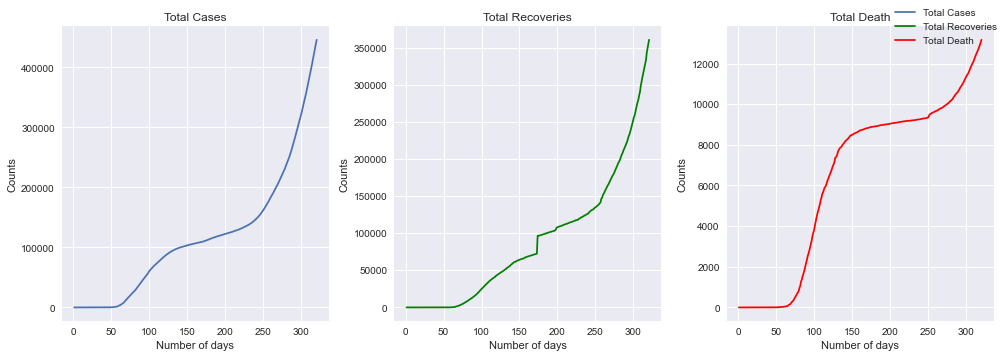

In [426]:
plt.style.use('seaborn')
fig = plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

axes[0].plot(canada_data['Num_of_days'], canada_data['Total_Cases'], label='Total Cases')
axes[0].set_title('Total Cases')
axes[0].set_xlabel('Number of days')
axes[0].set_ylabel('Counts')

axes[1].plot(canada_data['Num_of_days'], canada_data['Total_Recoveries'], color='green', label='Total Recoveries')
axes[1].set_title('Total Recoveries')
axes[1].set_xlabel('Number of days')
axes[1].set_ylabel('Counts')

axes[2].plot(canada_data['Num_of_days'], canada_data['Total_Death'], color='red', label='Total Death')
axes[2].set_title('Total Death')
axes[2].set_xlabel('Number of days')
axes[2].set_ylabel('Counts')

fig.legend()

plt.tight_layout()


In [440]:
max_case_winter = canada_data['2020-01-25':'2020-03-01']['New_Cases'].max()
max_case_spring = canada_data['2020-03-01':'2020-06-22']['New_Cases'].max()
max_case_summer = canada_data['2020-06-22':'2020-09-22']['New_Cases'].max()
max_case_fall = canada_data['2020-09-22':'2020-12-10']['New_Cases'].max()

max_new_cases = canada_data['New_Cases'].max()
max_new_death = canada_data['New_Death'].max()

print(f'Max new cases in Winter 2020: {max_case_winter}')
print(f'Max new cases in Sprint 2020: {max_case_spring}')
print(f'Max new cases in Summer 2020: {max_case_summer}')
print(f'Max new cases in Fall 2020: {max_case_fall}')


print(f'Max New Cases a day: {max_new_cases}')
print(f'Max New Death a day: {max_new_death}')

Max new cases in Winter 2020: 4
Max new cases in Sprint 2020: 2602
Max new cases in Summer 2020: 1394
Max new cases in Fall 2020: 7003
Max New Cases a day: 7003
Max New Death a day: 228


In [441]:
max_week_new_cases = canada_data['New_Cases'].resample('W').max()
max_week_active_cases = canada_data['Active_Cases'].resample('W').max()
max_week_new_recoveries = canada_data['New_Recoveries'].resample('W').max()                                 
max_week_deaths = canada_data['New_Death'].resample('W').max()

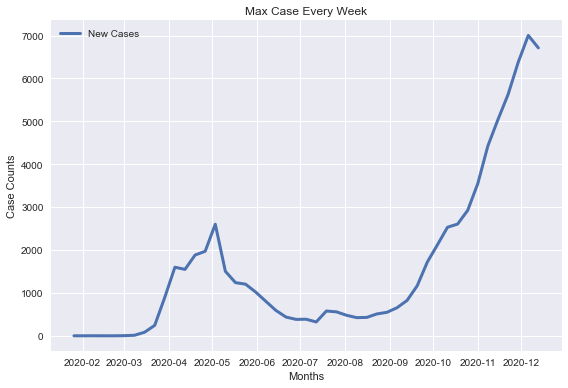

In [443]:
plt.style.use('seaborn')
plt.plot(max_week_new_cases, linewidth=3, label='New Cases')

plt.xlabel('Months')
plt.ylabel('Case Counts')
plt.title('Max Case Every Week')

plt.legend()


plt.tight_layout()

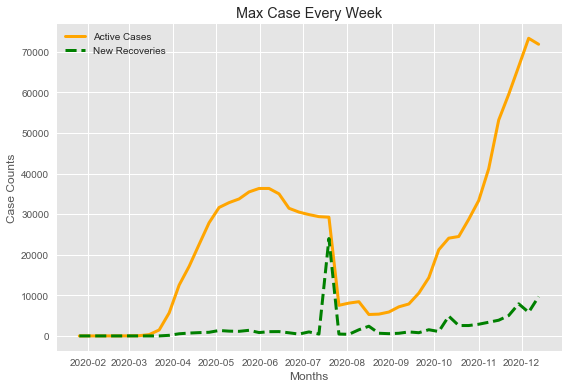

In [444]:
plt.style.use('ggplot')
plt.plot(max_week_active_cases, color='orange', linewidth=3, label='Active Cases')
plt.plot(max_week_new_recoveries, color='green', linewidth=3, linestyle='--', label='New Recoveries')

plt.xlabel('Months')
plt.ylabel('Case Counts')
plt.title('Max Case Every Week')

plt.legend()

plt.tight_layout()

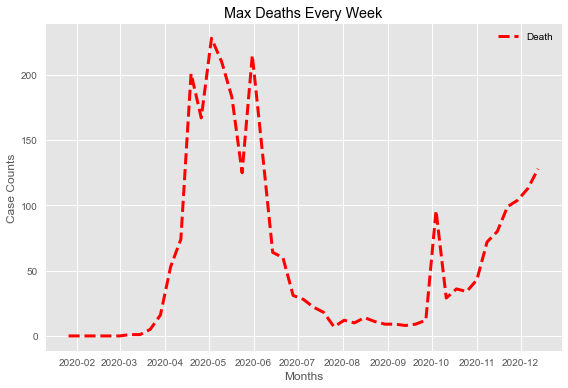

In [412]:
plt.plot(max_week_deaths, color='red', linewidth=3, linestyle='--', label='Death')

plt.xlabel('Months')
plt.ylabel('Case Counts')
plt.title('Max Deaths Every Week')

plt.legend()


plt.tight_layout()

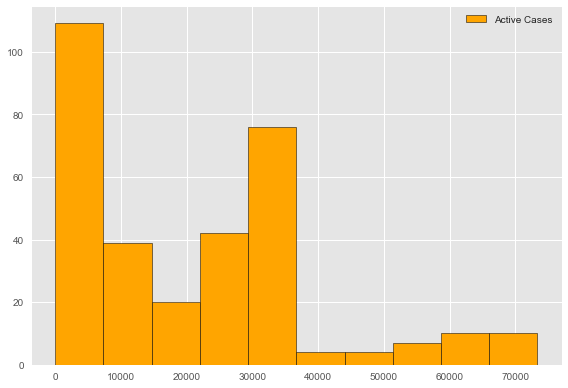

In [445]:
plt.style.use('ggplot')

plt.hist(active_cases, bins=10, color='orange', edgecolor='black', label="Active Cases")

plt.legend()


plt.tight_layout()



In [446]:
canada_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Num_of_days,321.0,161.000000,92.808944,1.0,81.0,161.0,241.0,321.0
New_Cases,321.0,1389.573209,1661.801015,0.0,338.0,681.0,1719.0,7003.0
New_Death,321.0,41.018692,50.970944,0.0,5.0,16.0,64.0,228.0
Active_Cases,321.0,20804.380062,18404.414762,1.0,5303.0,19167.0,31898.0,73344.0
New_Recoveries,321.0,1124.635514,1922.778238,0.0,253.0,553.0,1050.0,23999.0
Total_Cases,321.0,116589.236760,103865.743254,1.0,27871.0,106831.0,147407.0,446040.0
Total_Death,321.0,6405.408100,4238.586019,0.0,967.0,8712.0,9269.0,13167.0
Total_Recoveries,321.0,89379.448598,86886.933887,0.0,8235.0,68680.0,126925.0,361008.0


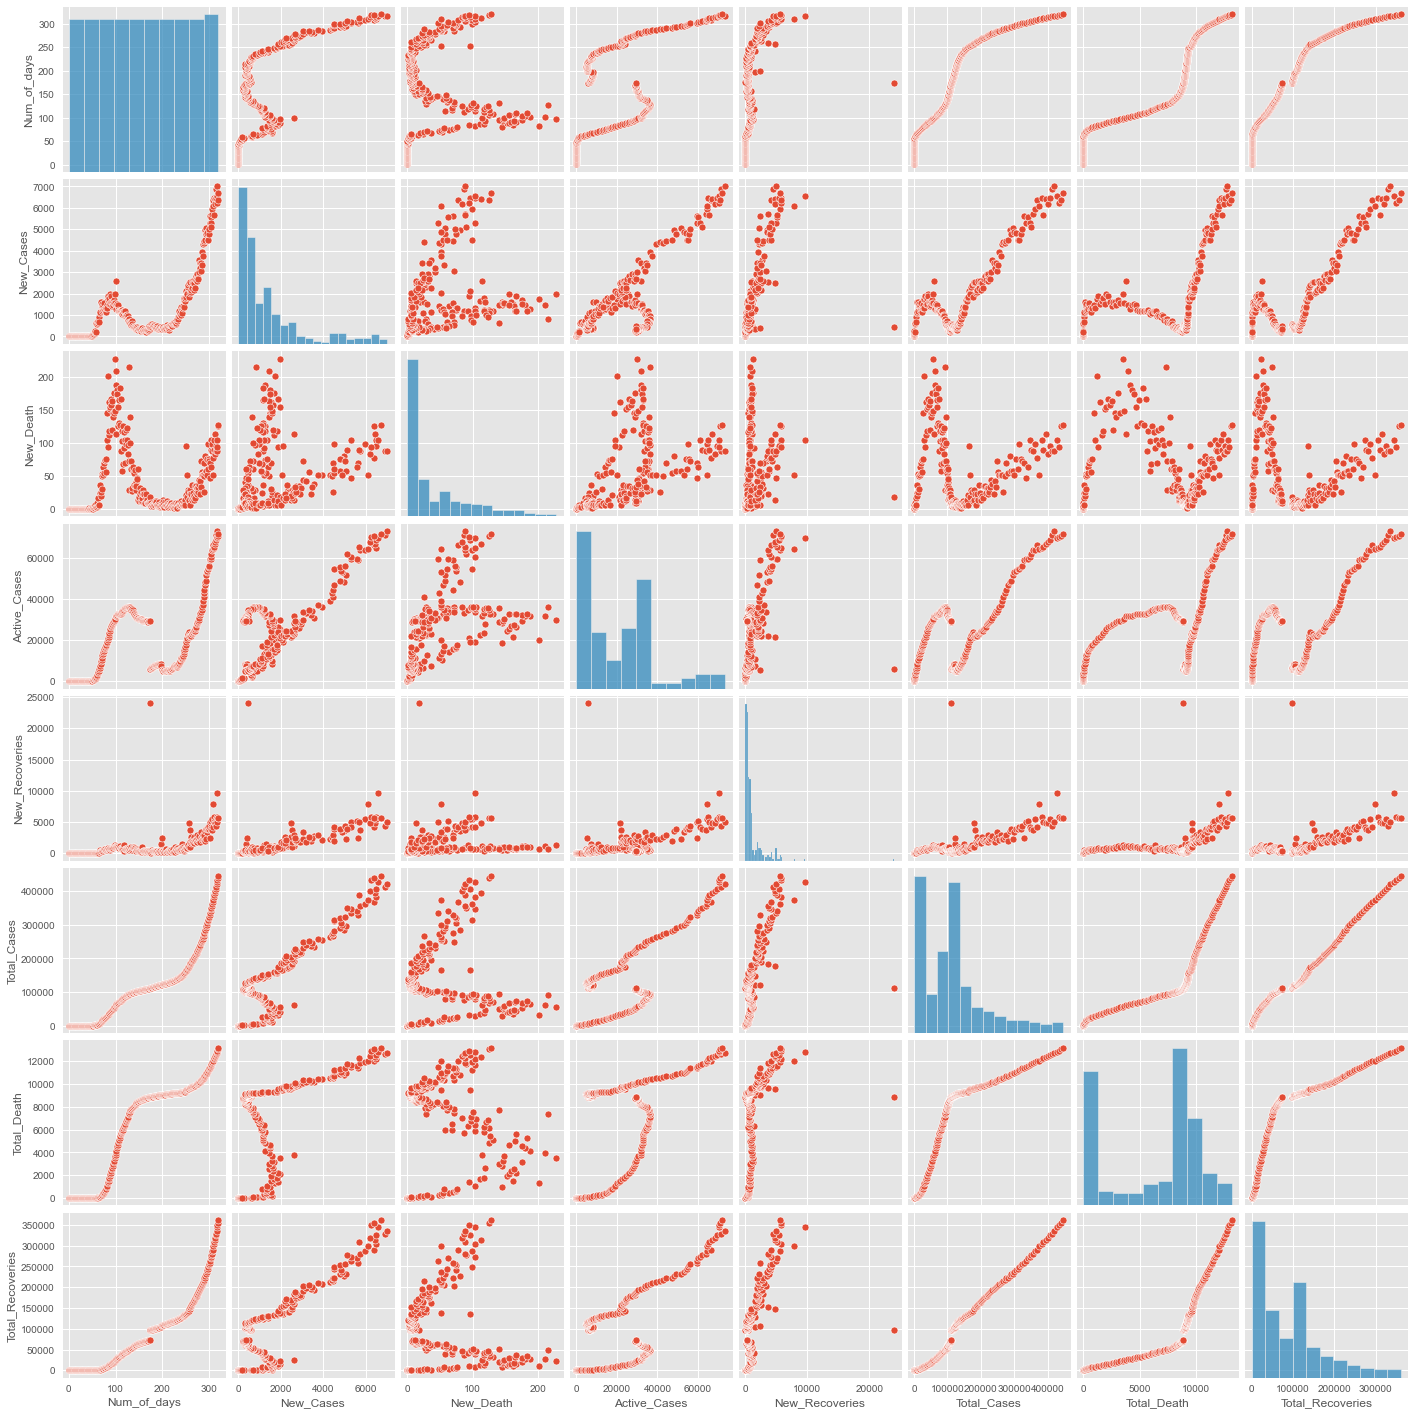

In [387]:
sns.pairplot(canada_data)

In [177]:
canada_data.columns

Index(['Num_of_days', 'New_Cases', 'New_Death', 'Active_Cases',
       'New_Recoveries', 'Total_Cases', 'Total_Death', 'Total_Recoveries'],
      dtype='object')

In [447]:
X = canada_data[['Num_of_days', 'New_Cases']]
y = canada_data['New_Recoveries']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=150)

In [448]:
lm = LinearRegression()

In [333]:
lm.fit(X_train, y_train)

LinearRegression()

In [322]:
print(lm.intercept_)

-155.06954324785806


In [334]:
print(lm.coef_)

[2.66 0.66]


In [335]:
X_train.columns

Index(['Num_of_days', 'New_Cases'], dtype='object')

In [336]:
pd.DataFrame(lm.coef_, X.columns, columns=['Coeff'])

,Coeff
Num_of_days,2.663298
New_Cases,0.661923


## Predictions

In [341]:
y_predictions = lm.predict(X_test)

In [456]:
d = {'Actual New Recoveries': y_test, 'Predicted New Recoveries': y_predictions}
df = pd.DataFrame(data=d)
df.to_csv('Predicted_New_Recoveries.csv', index=True)

Text(0.5, 1.0, 'Relationship between Actual and Predicted Recoveries')

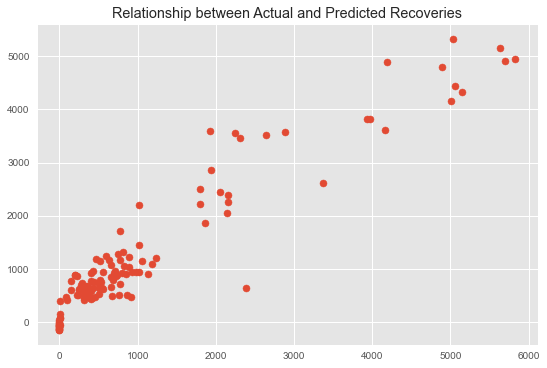

In [457]:
plt.scatter(y_test, y_predictions)
plt.title('Relationship between Actual and Predicted Recoveries')

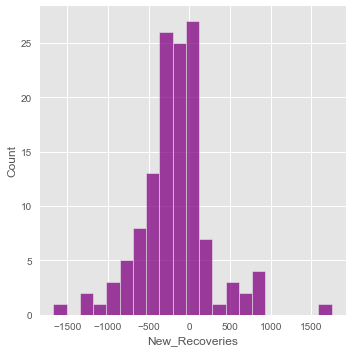

In [386]:
sns.displot((y_test - y_predictions), color='purple')

In [330]:
print(f'r^2: {metrics.r2_score(y_test, y_predictions)}')
print(f'rmse: {np.sqrt(metrics.mean_squared_error(y_test, y_predictions))}')

r^2: 0.8877456714845626
rmse: 468.9501851891274
